### Time walk correction

In [1]:
import sys,time
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy as np
# import data handling class
from DT5550_Waveform import *

In [2]:
filename = '../../data/20211214_115511/waveform_20211214_115511_0.raw'

In [74]:
#
print('Open datafile:',filename)
waves = DT5550_Waveform(file=filename)
trace = []
maxfound = 0
index_max = -1
while (waves.read_event() != -1):
    idet= 0
    #print('next event')
    for idet in range(N_DETECTOR):
        idx = 0
        for i in range(200):
            #print(i,waves.analog[idet,i],waves.digital[0,idet,i])
            if waves.digital[0,idet,i] == 1:
                idx = i+10
                break
        if idx>0:
            trace.append(waves.analog[idet,idx+12:idx+200]-waves.config['detector_settings'][idet]['BASE'])
            if trace[-1].max() > maxfound:
                maxfound = trace[-1].max()
                index_max = len(trace)-1

print(index_max)

Open datafile: ../../data/20211214_115511/waveform_20211214_115511_0.raw
6


Text(0, 0.5, 'timewalk (ns)')

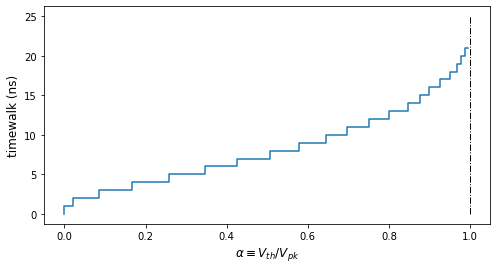

In [93]:
template = trace[index_max]/trace[index_max].max()
idx = template.argmax()
template = template[1:idx]
clock_bins = np.arange(0,len(template),1)

plt.figure(figsize=(8,4))
plt.plot(template,clock_bins,drawstyle='steps')
plt.plot([1,1],[0,25],'-.',linewidth=1,color='black')
plt.xlabel('$\\alpha \equiv V_{th}/V_{pk}$',fontsize=12)
plt.ylabel('timewalk (ns)',fontsize=12)
#plt.ylim([-0.1,1.1])

In [73]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
time = np.arange(0,290,1)
print(len(time),len(template))
template_smooth = lowess(template, time, is_sorted=True, frac=0.025, it=0)

In [ ]:
ran = (0,250)
plt.plot(template[0:200],drawstyle='steps')
plt.plot(template_smooth[0:200,0],template_smooth[0:200,1],drawstyle='steps')
plt.xlim(ran)
#plt.ylim([0,0.2])

In [ ]:
def find_t0(ToT_target,template):
    
    tcorr = 0
    vmin = 0
    vmax = 1
    
    
    idx=template.argmax()
    itry = 0

    scale = 0
    while(1):
        
        scale = (vmin+vmax)/2

        ft = template[0:idx] - scale
        t0 = len(ft[ft<0])
        
        ft = template[idx:-1] - scale
        t1 = len(ft[ft>0])+idx
    
        print(itry,' t0=',t0,' t1=',t1,' dt=',t1-t0)
        itry=itry+1
        
        ToT_meas = t1- t0
        
        if ToT_meas>ToT_target:
            vmin = scale
        else:
            vmax = scale
                
        if abs(ToT_meas-ToT_target)<1 or itry>100:
            break
    
    tcorr = t0
    
    return tcorr, scale

In [ ]:
ToT = 40

t0, S = find_t0(ToT,template_smooth[:,1])

In [ ]:
plt.plot(template_smooth[0:150,1])
plt.plot([t0,t0+ToT],[S,S],'-',color='red')
plt.axhline(0, color='black',linewidth=1)
